<a href="https://colab.research.google.com/github/Radi4/DL_colab/blob/master/homework_part2_solved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 2.2: The Quest For A Better Network

In this assignment you will build a monster network to solve Tiny ImageNet image classification.

This notebook is intended as a sequel to seminar 3, please give it a try if you haven't done so yet.

(please read it at least diagonally)

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.
* There is a __mini-report__ at the end that you will have to fill in. We recommend reading it first and filling it while you iterate.
 
## Grading
* starting at zero points
* +20% for describing your iteration path in a report below.
* +20% for building a network that gets above 20% accuracy
* +10% for beating each of these milestones on __TEST__ dataset:
    * 25% (50% points)
    * 30% (60% points)
    * 32.5% (70% points)
    * 35% (80% points)
    * 37.5% (90% points)
    * 40% (full points)
    
## Restrictions
* Please do NOT use pre-trained networks for this assignment until you reach 40%.
 * In other words, base milestones must be beaten without pre-trained nets (and such net must be present in the anytask atttachments). After that, you can use whatever you want.
* you __can't__ do anything with validation data apart from running the evaluation procedure. Please, split train images on train and validation parts

## Tips on what can be done:


 * __Network size__
   * MOAR neurons, 
   * MOAR layers, ([torch.nn docs](http://pytorch.org/docs/master/nn.html))

   * Nonlinearities in the hidden layers
     * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

   * Ph'nglui mglw'nafh Cthulhu R'lyeh wgah'nagl fhtagn!


### The main rule of prototyping: one change at a time
   * By now you probably have several ideas on what to change. By all means, try them out! But there's a catch: __never test several new things at once__.


### Optimization
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum
   * You should certainly use adaptive optimizers
     * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (nn.BatchNorm2d) for the win!
     * Sometimes more batch normalization is better.
   * __Regularize__ to prevent overfitting
     * Add some L2 weight norm to the loss function, PyTorch will do the rest
       * Can be done manually or like [this](https://discuss.pytorch.org/t/simple-l2-regularization/139/2).
     * Dropout (`nn.Dropout`) - to prevent overfitting
       * Don't overdo it. Check if it actually makes your network better
   
### Convolution architectures
   * This task __can__ be solved by a sequence of convolutions and poolings with batch_norm and ReLU seasoning, but you shouldn't necessarily stop there.
   * [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions (exotic)](https://arxiv.org/abs/1608.06993), [Capsule networks (exotic)](https://arxiv.org/abs/1710.09829)
   * Please do try a few simple architectures before you go for resnet-152.
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment that you try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.
 
   
### Data augmemntation
   * getting 5x as large dataset for free is a great 
     * Zoom-in+slice = move
     * Rotate+zoom(to remove black stripes)
     * Add Noize (gaussian or bernoulli)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
     * Other cool libraries: cv2, skimake, PIL/Pillow
   * A more advanced way is to use torchvision transforms:
    ```
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    trainset = torchvision.datasets.ImageFolder(root=path_to_tiny_imagenet, train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    ```
   * Or use this tool from Keras (requires theano/tensorflow): [tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), [docs](https://keras.io/preprocessing/image/)
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.
   


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import os
from collections import defaultdict
from tqdm import tqdm_notebook, trange, tqdm
import torchvision
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import transforms
from torchsummary import summary
%matplotlib inline

In [0]:
#set random seed
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [0]:
#download data on colab
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/spring2019/week03_convnets/tiny_img.py -O tiny_img.py

--2019-03-15 11:21:36--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/spring2019/week03_convnets/tiny_img.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3378 (3.3K) [text/plain]
Saving to: ‘tiny_img.py’

tiny_img.py         100%[===================>]   3.30K  --.-KB/s    in 0s      

2019-03-15 11:21:36 (53.4 MB/s) - ‘tiny_img.py’ saved [3378/3378]



In [0]:
#download dataset
from tiny_img import download_tinyImg200
data_path = '.'
download_tinyImg200(data_path)

./tiny-imagenet-200.zip


Скрипт для перекладывания картинок в папке val

In [0]:
if os.path.exists('./tiny-imagenet-200/val/val_annotations.txt'):
    classes = defaultdict(list)

    with open('./tiny-imagenet-200/val/val_annotations.txt', 'r') as f:
        for line in f:
            line = line.strip()
            name, clas, data = line.split('\t', 2)
            classes[clas].append(([name, data]))
    
    subprocess.call(['rm', '-r', './tiny-imagenet-200/val/val_annotations.txt'])

    val_dir = os.path.join('tiny-imagenet-200', 'val', 'images')

    for clas in tqdm(classes):
    
        subprocess.call(['mkdir', os.path.join('tiny-imagenet-200', 'val', clas)])
        subprocess.call(['mkdir', os.path.join('tiny-imagenet-200', 'val', clas, 'images')])

        new_dir = os.path.join('tiny-imagenet-200', 'val', clas)
        new_file = os.path.join(new_dir, clas + '_boxes.txt')
        new_dir = os.path.join(new_dir, 'images')

        subprocess.call(['touch', new_file])
        with open(new_file, 'w') as out:
            for name, data in classes[clas]:
                out.write(name + '\t' + data + '\n')
                subprocess.call(['mv', os.path.join(val_dir, name), new_dir + '/'])
    
    subprocess.call(['rm', '-r', val_dir])

100%|██████████| 200/200 [01:34<00:00,  1.71it/s]


In [0]:
# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [0]:
def compute_loss(X_batch, y_batch):
    X_batch = Variable(torch.FloatTensor(X_batch)).cuda()
    y_batch = Variable(torch.LongTensor(y_batch)).cuda()
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [0]:
means = np.array((0.4914, 0.4822, 0.4465))
stds = np.array((0.2023, 0.1994, 0.2010))

transform_augment = transforms.Compose([
    torchvision.transforms.RandomCrop(64),
    torchvision.transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    torchvision.transforms.Normalize(means, stds),
])

dataset = torchvision.datasets.ImageFolder('tiny-imagenet-200/train', transform=transform_augment)

In [0]:
#I change your spliting to increase train dataset
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [90000, 10000])

In [0]:
model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding = 1, bias = False))
model.add_module('norm1', nn.BatchNorm2d(64))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(2))
model.add_module('conv2', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding = 1, bias = False))
model.add_module('norm2', nn.BatchNorm2d(128))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(2))
model.add_module('conv3', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding = 1, bias = False))
model.add_module('norm3', nn.BatchNorm2d(256))
model.add_module('relu3', nn.ReLU())
model.add_module('conv4', nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding = 1, bias = False))
model.add_module('norm4', nn.BatchNorm2d(512))
model.add_module('relu4', nn.ReLU())
model.add_module('pool3', nn.MaxPool2d(2))
model.add_module('flat', Flatten())
model.add_module('linear_-3', nn.Linear(16384 * 2, 4096 * 2))
model.add_module('norm_-2', nn.BatchNorm1d(4096 * 2))
model.add_module('relu_-2', nn.ReLU())
model.add_module('droput_-2', nn.Dropout(0.5))
model.add_module('linear_-2', nn.Linear(4096 * 2, 500))
model.add_module('norm_-1', nn.BatchNorm1d(500))
model.add_module('relu_-1', nn.ReLU())
model.add_module('droput_-1', nn.Dropout(0.5))


model.add_module('dense1_logits', nn.Linear(500, 200)) # logits for 200 classes
model = model.cuda()
summary(model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,728
       BatchNorm2d-6          [-1, 128, 32, 32]             256
              ReLU-7          [-1, 128, 32, 32]               0
         MaxPool2d-8          [-1, 128, 16, 16]               0
            Conv2d-9          [-1, 256, 16, 16]         294,912
      BatchNorm2d-10          [-1, 256, 16, 16]             512
             ReLU-11          [-1, 256, 16, 16]               0
           Conv2d-12          [-1, 512, 16, 16]       1,179,648
      BatchNorm2d-13          [-1, 512, 16, 16]           1,024
             ReLU-14          [-1, 512,

In [0]:
opt = torch.optim.Adagrad(model.parameters(), lr = 0.01)

train_loss = []
val_accuracy = []

In [12]:
import time
num_epochs = 15 # total amount of full passes over training data
batch_size = 100  # number of samples processed in one SGD iteration

train_batch_gen = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=1)
val_batch_gen = torch.utils.data.DataLoader(val_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=1)

for epoch in tqdm(range(num_epochs)):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for (X_batch, y_batch) in train_batch_gen:
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.cpu().data.numpy())
    print(epoch)    
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in val_batch_gen:
        logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
        y_pred = logits.max(1)[1].data
        val_accuracy.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(train_dataset) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(val_dataset) // batch_size :]) * 100))

  0%|          | 0/15 [00:00<?, ?it/s]

0


  7%|▋         | 1/15 [06:47<1:34:58, 407.03s/it]

Epoch 1 of 15 took 407.028s
  training loss (in-iteration): 	4.311684
  validation accuracy: 			18.57 %
1


 13%|█▎        | 2/15 [13:34<1:28:13, 407.16s/it]

Epoch 2 of 15 took 407.472s
  training loss (in-iteration): 	3.545629
  validation accuracy: 			24.98 %
2


 20%|██        | 3/15 [20:22<1:21:27, 407.26s/it]

Epoch 3 of 15 took 407.499s
  training loss (in-iteration): 	3.225499
  validation accuracy: 			29.21 %
3


 27%|██▋       | 4/15 [27:09<1:14:40, 407.28s/it]

Epoch 4 of 15 took 407.329s
  training loss (in-iteration): 	3.003035
  validation accuracy: 			32.02 %
4


 33%|███▎      | 5/15 [33:56<1:07:53, 407.39s/it]

Epoch 5 of 15 took 407.633s
  training loss (in-iteration): 	2.815432
  validation accuracy: 			34.28 %
5


 40%|████      | 6/15 [40:44<1:01:07, 407.50s/it]

Epoch 6 of 15 took 407.763s
  training loss (in-iteration): 	2.643972
  validation accuracy: 			36.59 %
6


 47%|████▋     | 7/15 [47:32<54:20, 407.54s/it]  

Epoch 7 of 15 took 407.611s
  training loss (in-iteration): 	2.488070
  validation accuracy: 			37.43 %
7


 53%|█████▎    | 8/15 [54:18<47:30, 407.20s/it]

Epoch 8 of 15 took 406.403s
  training loss (in-iteration): 	2.334670
  validation accuracy: 			38.82 %
8


 60%|██████    | 9/15 [1:01:04<40:41, 406.86s/it]

Epoch 9 of 15 took 406.076s
  training loss (in-iteration): 	2.182929
  validation accuracy: 			39.98 %
9


 67%|██████▋   | 10/15 [1:07:50<33:53, 406.61s/it]

Epoch 10 of 15 took 406.021s
  training loss (in-iteration): 	2.018911
  validation accuracy: 			40.45 %
10


 73%|███████▎  | 11/15 [1:14:38<27:07, 406.90s/it]

Epoch 11 of 15 took 407.569s
  training loss (in-iteration): 	1.867688
  validation accuracy: 			41.51 %
11


 80%|████████  | 12/15 [1:21:26<20:21, 407.10s/it]

Epoch 12 of 15 took 407.575s
  training loss (in-iteration): 	1.708401
  validation accuracy: 			41.13 %
12


 87%|████████▋ | 13/15 [1:28:13<13:34, 407.24s/it]

Epoch 13 of 15 took 407.554s
  training loss (in-iteration): 	1.553635
  validation accuracy: 			41.80 %
13


 93%|█████████▎| 14/15 [1:35:01<06:47, 407.32s/it]

Epoch 14 of 15 took 407.514s
  training loss (in-iteration): 	1.393456
  validation accuracy: 			41.69 %
14


100%|██████████| 15/15 [1:41:48<00:00, 407.42s/it]

Epoch 15 of 15 took 407.633s
  training loss (in-iteration): 	1.242678
  validation accuracy: 			42.43 %


When everything is done, please calculate accuracy on `tiny-imagenet-200/val`

In [0]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

batch_size = 100
test_dataset = torchvision.datasets.ImageFolder('tiny-imagenet-200/val', transform=transform_test)
test_batch_gen = torch.utils.data.DataLoader(test_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=1)

model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in test_batch_gen:
    logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
    y_pred = logits.max(1)[1].data
    test_batch_acc.append(np.mean( (y_batch.cpu().data == y_pred.cpu().data).numpy() ))


test_accuracy = np.mean(test_batch_acc)

In [0]:
import matplotlib.pyplot as plt
import seaborn as sb
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (10, 8)

Text(0.5, 1.0, 'Loss on train')

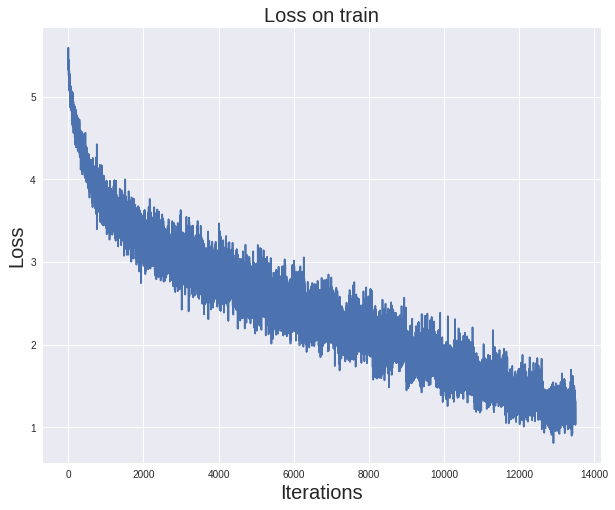

In [16]:
plt.plot(range(len(train_loss)), train_loss)
plt.xlabel('Iterations', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.title('Loss on train', fontsize = 20)

In [0]:
train_loss_epochs = []
step = len(train_loss) // num_epochs
for i in range(0, len(train_loss), step):
  ssum = sum(train_loss[i : i + step])
  train_loss_epochs.append(ssum / step)

Text(0.5, 1.0, 'Loss on train')

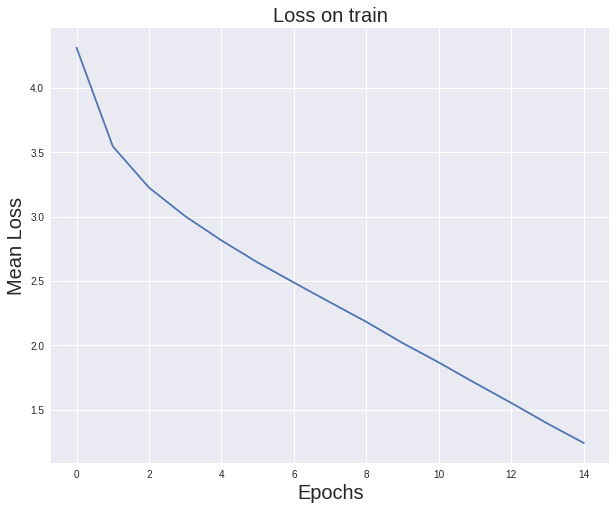

In [26]:
plt.plot(range(len(train_loss_epochs)), train_loss_epochs)
plt.xlabel('Epochs', fontsize = 20)
plt.ylabel('Mean Loss', fontsize = 20)
plt.title('Loss on train', fontsize = 20)

Text(0.5, 1.0, 'Accuracy on val')

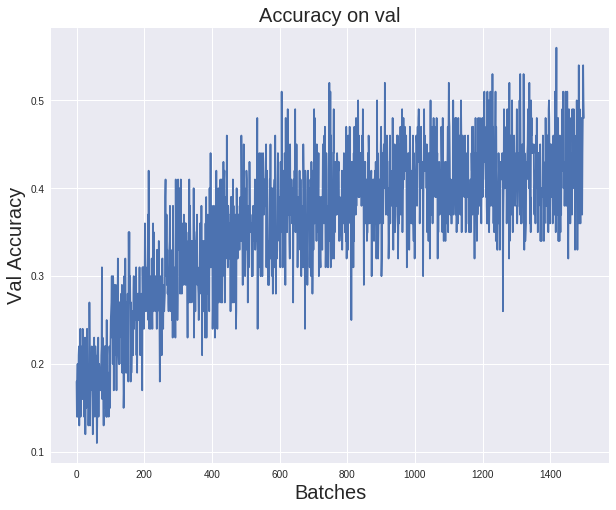

In [28]:
plt.plot(range(len(val_accuracy)), val_accuracy)
plt.xlabel('Batches', fontsize = 20)
plt.ylabel('Val Accuracy', fontsize = 20)
plt.title('Accuracy on val', fontsize = 20)

In [14]:
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 40:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 35:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 30:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 25:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		42.08 %
Achievement unlocked: 110lvl Warlock!


```

```

```

```

```

```


# Report

All creative approaches are highly welcome, but at the very least it would be great to mention
* the idea;
* brief history of tweaks and improvements;
* what is the final architecture and why?
* what is the training method and, again, why?
* Any regularizations and other techniques applied and their effects;


There is no need to write strict mathematical proofs (unless you want to).
 * "I tried this, this and this, and the second one turned out to be better. And i just didn't like the name of that one" - OK, but can be better
 * "I have analized these and these articles|sources|blog posts, tried that and that to adapt them to my problem and the conclusions are such and such" - the ideal one
 * "I took that code that demo without understanding it, but i'll never confess that and instead i'll make up some pseudoscientific explaination" - __not_ok__

### Hi, my name is `___ ___`, and here's my story

A long time ago in a galaxy far far away, when it was still more than an hour before the deadline, i got an idea:

##### I gonna build a neural network, that
* brief text on what was
* the original idea
* and why it was so

How could i be so naive?!

##### One day, with no signs of warning,
This thing has finally converged and
* Some explaination about what were the results,
* what worked and what didn't
* most importantly - what next steps were taken, if any
* and what were their respective outcomes

##### Finally, after __  iterations, __ mugs of [tea/coffee]
* what was the final architecture
* as well as training method and tricks

That, having wasted ____ [minutes, hours or days] of my life training, got

* accuracy on training: __
* accuracy on validation: __
* accuracy on test: __


[an optional afterword and mortal curses on assignment authors]